# Recommendation model based on OTTO dataset

This notebook loads the normalized version of [the OTTO session dataset](https://www.kaggle.com/datasets/otto/recsys-dataset?select=otto-recsys-train.jsonl).

We aim is to solve three tasks:

1. Provide the top-seller products from their shop
1. Identifying frequently bought together (FreBoTo) items
1. The customer requests real-time recommendation

The dataset has been normalized (see [prep-data.ipynb](./prep-data.ipynb)) from the original json format into a table with the schema:

```python
meta = {
    "aid": np.int64,
    "ts": np.int64,
    "type": np.str,
    "session": np.int64,
}
```

where 
* `aid` is the `article id` of a product
* `ts` is the timestamp in epoch format
* `type` is an enum of `{"clicks","carts","orders"}` representing the user _clicking on the product_, _adding the product to their basket_, and _placing an order that includes that product_, respectively.
* `session` is the session id. From the dataset documentation: _"A session is all activity by a single user either in the train or the test set."_

> NOTE: Preferably, we would store and load the dataset in some kind of cloud-enabled storage to keep this book
> portable and reproducible, but this is outside the scope of this book.

_All_ IDs are anonymized, i.e. it's pretty hard to present an intuition about the results. As an example, you cannot look up the products, as they are no longer related to the products from `OTTO`. We have to rely solely on our evaluation scores with this data.

## Approach

We identify problem 2 (_Identifying frequently bought together (FreBoTo) items_) as the most challenging part, as it leaves the most room for interpretation while also inviting a machine-learning based approach.

To solve this problem, we focus on the `orders` in a session and treat it as a Natural Language Processing (NLP). Namely, we can treat the sequence of orders in a session as _a sentence_ in NLP and solve the problem as *Next Event Predition* (NEP) task. 

If we look at a session in isolation, the NEP task would be, given the history of ordered articles, **what is the most likely product that the customer would buy next**.

![](FF19_Artboard_10rev.png)
> (Image from https://session-based-recommenders.fastforwardlabs.com/)


In this notebook, we choose the [`Word2Vec`](https://en.wikipedia.org/wiki/Word2vec) approach to solve this problem. The [Gensim](https://radimrehurek.com/gensim/) library has an implementation of this training algorithm which we will use ([see specificly this link](https://radimrehurek.com/gensim/models/word2vec.html)).
We are using the `skip-gram` algorithm configuration, specifically.

To assess our solution, we use [`Recall at K`](https://en.wikipedia.org/wiki/Evaluation_measures_(information_retrieval)#Recall) and [`Mean Reciprocal Rank at K`](https://en.wikipedia.org/wiki/Mean_reciprocal_rank) to score the model against the "ground truth", i.e. based on the `n-1`th order, how likely are we to recommend the `n`th item from that session.

We compare the 2 scores to a random algorithm which picks `K` random elements from a given vocabulary (the _vocabulary_ is the full list of `aid`s we see in the dataset).

## Unsolved problems

We do not solve the **cold start problem**, where, i.e., a new product is launched and not recommended, since the algorithm has no prior order history which includes this product. This could be solved as part of `problem 3` at the time of providing recommendations through an `API`, or possibly presented with a "hero spot" on the webpage until enough history can be gathered.

We do not tune the **hyperparameters**, though this could possibly increase our score dramatically. 

## Dataset

We use only the main dataset ('otto-recsys-train.jsonl') and split the sessions into training and test data manually. This is a bit more flexible and suits the `Word2Vec` approach.


In [17]:
# Import libraries and print versions
import sys

import dask.dataframe as dd
import pandas as pd
import platform
from typing import List

print(f"Running on machine: {platform.uname()}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")

Running on machine: uname_result(system='Darwin', node='dkfepaha.local', release='22.6.0', version='Darwin Kernel Version 22.6.0: Wed Jul  5 22:22:05 PDT 2023; root:xnu-8796.141.3~6/RELEASE_ARM64_T6000', machine='arm64')

Python 3.9.15 | packaged by conda-forge | (main, Nov 22 2022, 08:52:10) 
[Clang 14.0.6 ]
Pandas 1.4.4


In [18]:
# Start a Dask Client for a local cluster (automatically started)
from dask.distributed import Client
client = Client()
client

/Users/dkFePaHa/miniconda3/envs/tensorflow/lib/python3.9/site-packages/distributed/node.py:183: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 63331 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:63331/status,
Dashboard: http://127.0.0.1:63331/status,Workers: 5
Total threads: 10,Total memory: 32.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:63332,Workers: 5
Dashboard: http://127.0.0.1:63331/status,Total threads: 10
Started: Just now,Total memory: 32.00 GiB
Comm: tcp://127.0.0.1:63352,Total threads: 2
Dashboard: http://127.0.0.1:63359/status,Memory: 6.40 GiB
Nanny: tcp://127.0.0.1:63338,


In [19]:
# Read the normalized dataset into a Dask DataFrame
# We continue to work with the Dask DataFrame as long as possible as it supports lazy evaluation
normalized = dd.read_parquet(f"archive/otto-recsys-train.jsonl-parquet")

In [20]:
mask = normalized["type"] == "orders"  ## only orders

orders = normalized[mask]  ## filter out orders


sessions_with_orders = len(orders["session"].unique())
session_number = len(normalized["session"].unique())
vocabulary = (
    normalized["aid"].unique().compute().tolist()
)  # we need this for the random baseline model later
unique_aids = len(vocabulary)
percentage_with_purchase = sessions_with_orders / session_number * 100

total_orders = len(orders)
average_order_per_buying_session = total_orders / sessions_with_orders

normalized[mask].groupby("session")

MINIMUM_ORDERS = 2

sessions_with_more_than_k_orders = orders.map_partitions(
    lambda df: df.groupby("session").filter(lambda x: len(x) > MINIMUM_ORDERS)
) ## we assume that each dask-partition contains full-sessions. TODO: recheck assumption

num_sessions_with_more_than_k_orders = len(
    sessions_with_more_than_k_orders["session"].unique()
)

print(f"Number of unique aids: {unique_aids}")

print(f"Total number of orders: {total_orders}")
print(
    f"Average number of orders per buying session: {average_order_per_buying_session}"
)

print(
    f"Number of sessions with more than 3 orders: {num_sessions_with_more_than_k_orders}"
)

print(f"Number of sessions with orders: {sessions_with_orders}")
print(f"Percentage of sessions with orders: {percentage_with_purchase:.2f}%")

Number of unique aids: 1855603
Total number of orders: 5098951
Average number of orders per buying session: 3.1352344961502467
Number of sessions with more than 3 orders: 602169
Number of sessions with orders: 1626338
Percentage of sessions with orders: 12.61%


The 10 most popular products: 231487     4485
166037     3824
1733943    3042
1445562    2998
1022566    2788
801774     2710
1629608    2628
756588     2593
332654     2436
1603001    2353
Name: aid, dtype: int64


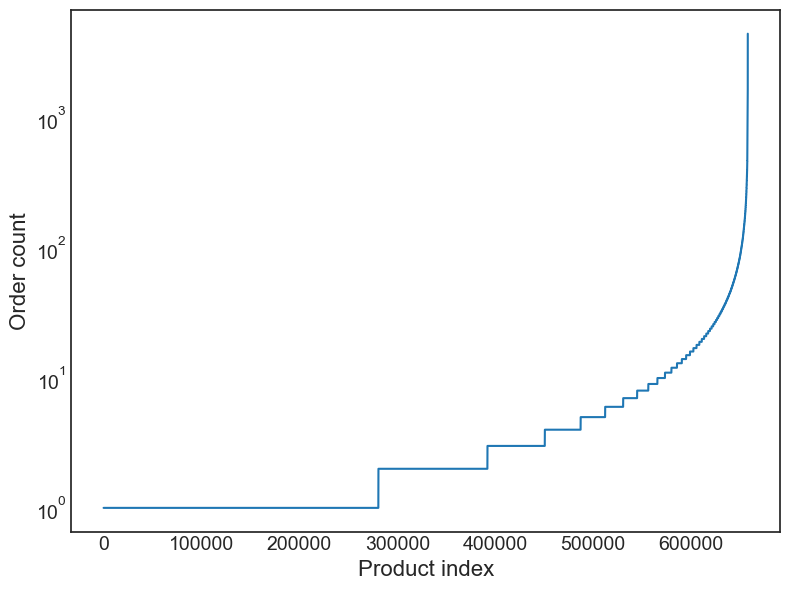

In [21]:
# We find the 10 most popular `aid`s (basically solves problem 1)

import matplotlib.pyplot as plt

# orders["aid"].value_counts().compute().plot(kind="bar")

plt.style.use("seaborn-white")

# Number of unique customer IDs
product_counts = orders["aid"].value_counts().values.compute()


fig = plt.figure(figsize=(8,6))
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)

plt.semilogy(sorted(product_counts))
plt.ylabel("Order count", fontsize=16);
plt.xlabel("Product index", fontsize=16);

plt.tight_layout()

ten_most_popular = orders["aid"].value_counts().nlargest(10).compute()
print(f"The 10 most popular products: {ten_most_popular}")

As we can see, the distribution of product purchases is very tail-heavy meaning we have a large vocabulary of words that are almost never used. More than 2/3 of the products are purchased less `<10` times, whereas the popular products are purchased `>1000` times.

In [ ]:
filtered = sessions_with_more_than_k_orders[["aid","session"]] # discard timestamps and type
filtered.compute()

,aid,session
8,305831,0
9,461689,0
245,1199474,0
246,543308,0
360,357461,3
...,...,...
959388,465366,12899355
960085,1488793,12899525
960086,1599360,12899525
960087,996393,12899525


In [ ]:
# we get the final session data in memory.
# NOTE: This does not scale for even larger datasets, but it is not clear if gensim supports dask dataframes
# At least this fits the requirement that the input needs to be a "restartable" iterator.
orders_by_session: List[List[int]] = (
    filtered.compute().groupby("session").agg(list)["aid"].values.tolist()
) 
print(len(orders_by_session))

602169


In [ ]:
# We split the data into train, test and validation sets
from split import train_test_split
print(f"orders_by_session has {len(orders_by_session)} sessions")
test_size = 3000 # this affects the scoring time and accuracy
assert test_size < len(orders_by_session), "test_size must be smaller than the number of sessions"

train, test, valid = train_test_split(orders_by_session, test_size=test_size)

orders_by_session has 602169 sessions


In [26]:
"""
Finally, we train the model and score it.
We then compare it to the score of a random baseline model.
"""

from gensim.models import Word2Vec
from evaluation import recall_at_k, mrr_at_k, RandomEmbeddings
from LossLogger import LossLogger
import os

epochs = 20

print(f"Training Word2Vec model on {len(train)} sessions")

loss_logger = LossLogger(epochs)

model = Word2Vec(
    train,
    min_count=1,
    sg=1,
    workers=8,
    epochs=epochs,
    window=10,
    compute_loss=True,
    callbacks=[loss_logger],
)

print("Saving model")
model.save("word2vec.model")
model_size_in_mb = os.path.getsize("word2vec.model") / (1024 * 1024)
print(f"Model size: {model_size_in_mb:.2f}mb")


embeddings = model.wv  # "word vectors"

Training Word2Vec model on 602169 sessions


100%|██████████| 10/10 [00:56<00:00,  5.70s/epoch]


Losses: [(0, 7204853.5), (1, 11679880.0), (2, 14929072.0), (3, 17570776.0), (4, 19832696.0), (5, 22052152.0), (6, 24158462.0), (7, 26192090.0), (8, 28273390.0)]
Saving model
Model size: 12.46mb


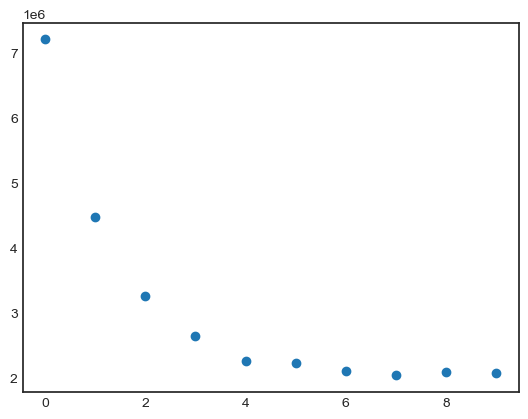

In [27]:
import matplotlib.pyplot as plt

plt.scatter(x=range(0, epochs), y=loss_logger.delta_losses)

In [30]:
# Score the model against the random model
from tqdm import tqdm
K = 20

random_embeddings = RandomEmbeddings(vocabulary)

print(f"Evaluating model with 'recall@{K}'")
recall_score = recall_at_k(tqdm(test), embeddings, k=K)
recall_score_random = recall_at_k(tqdm(test), random_embeddings, k=K)
print(f"Model recall@{K} score: {recall_score}")
print(f"Random recall@{K} score: {recall_score_random}")

print(f"Evaluating model with 'mrr@{K}'")
mrr_score = mrr_at_k(tqdm(test), embeddings, k=K)
mrr_score_random = mrr_at_k(tqdm(test), random_embeddings, k=K)
print(f"Model mrr@{K} score: {mrr_score}")
print(f"Random mrr@{K} score: {mrr_score_random}")

Evaluating model with 'recall@20'


100%|██████████| 3000/3000 [00:05<00:00, 522.81it/s]


Model recall@20 score: 0.041
Random recall@20 score: 0.0006666666666666666
Evaluating model with 'mrr@20'


100%|██████████| 3000/3000 [00:05<00:00, 522.10it/s]

Model mrr@20 score: 0.016743332388572334
Random mrr@20 score: 0.0
